# Hands-on Machine Learning 
# Chapter 05 - Support Vector Machines

# Imports

In [44]:
# Python >= 3.5 is required
import sys 
assert sys.version_info >= (3, 5)

# Scikit-Learn version >= 0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports 
import numpy as np
import os

# To make the notebook's outputs consistent across runs
np.random.seed(42)

# To plot pretty figures
import matplotlib.pyplot as plt
import matplotlib as mpl 
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Saving figures in an images folder in same directory
PROJECT_ROOT_DIR = "."
IMAGES_DIR = "images"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, IMAGES_DIR)
os.makedirs(IMAGES_PATH, exist_ok=True)

# Function to save figures
def save_fig(fig_id, tight_layout=True, fig_extension='png', resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)


# Large Margin Classification 
- Compares a linear SVM classifier with conventional linear classifiers.
- Classification boundaries of conventional linear classifiers are often such that they intersect almost exactly with the farthest points or outliers of a class.
- Such classifiers will not generalize well.
- An SVM is large margin classifier: it's cost function aims to maximise the distance between the closest sample of a class and the decision boundary. 
    - In other words, it aims to maximise the distance between the closest samples of two separate classes.
    - The margin is the distance between the classification boundary and the closest sample.
    - By maximising the margin, it effectively tries to fit 'as wide a street as possible' between the two classes.
- SVM decision boundaries are not affected by all samples - only by the ones closest to the classification boundary.
    - In other words, the classification boundary will shift only if the new samples are closer to the previous classification boundary than the last closest samples. 
    - In $n$-dimensional space, each sample is an $n$-dimensional vector.
    - The classification boundary is said to be fully supported or determined by the vectors representing the two closest samples of the classes to be separated.
- This is why SVMs are called **large margin classifiers**.

## Loading Data

In [2]:
# For instantiating support vector classifiers
from sklearn.svm import SVC

# For loading the iris dataset
from sklearn import datasets

In [3]:
# Load the iris dataset
iris = datasets.load_iris()

# Extract the features - petal length and petal width
X = iris['data'][:, (2, 3)]   # All rows, only columns 2 and 3
y = iris['target']

# Extracting samples that belong to either setosa or versicolor for binary dataset
setosa_or_versicolor = (y == 0) | (y == 1)
X = X[setosa_or_versicolor]
y = y[setosa_or_versicolor]

In [4]:
# Building a (linear) support vector classifier
svm_clf = SVC(kernel='linear', C=float('inf'))

# Fitting to the data
svm_clf.fit(X, y)

SVC(C=inf, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

`C` is a regularization parameter. In SVM classifiers, it controls the the tradeoff between hard and soft margin classifiers. The larger the value of `C`, the narrower the margin, but the fewer the margin violations - thus, higher value of `C` means **hard margin** classifier.

## Bad Linear Models

To contextualise the benefit of using SVMs, we are going to compare the decision boundaries of an SVM classifier and a conventional linear model side by side. We'll find that the SVM is likely to generalize better because the decision boundary aims to maximise the distance between itself and the closest sample of a class. Without this constraint, models tend to come too close to the samples of a class. 

In [5]:
# Domain of x for which the classifier boundaries will be plotted
x_0 = np.linspace(0, 5.5, 200)

# Linear classification boundaries
pred_1 = 5 * x_0 - 20
pred_2 = x_0 - 1.8 
pred_3 = 0.1 * x_0 + 0.5

In [18]:
def plot_svc_decision_boundary(svm_clf, xmin, xmax):
    """Extracts weights and bias from an SVM classifier and plots its support vectors"""
    w = svm_clf.coef_[0]        # Kernel or weights
    b = svm_clf.intercept_[0]   # Also known as the bias
    
    # At the decision boundary, w_0 * x_0 + w_1 * x_1 + b = 0
    # So x_1 = -w_0/w_1 * x_0 - b/w_1 
    
    # Possible values of 0th feature same as domain of values to visualize
    x_0 = np.linspace(xmin, xmax, 200)    
    
    # Decision boundary represented by x_1 
    decision_boundary = -w[0] / w[1] * x_0 - b/w[1]
    
    # Margin - the perpendicular distance between a support vector and classification boundary
    margin = 1 / w[1]
    
    # Upper and lower gutters are the lines passing through the support vectors
    gutter_up = decision_boundary + margin 
    gutter_down = decision_boundary - margin 
    
    # Extract the support vectors from the SVM object
    support_vectors = svm_clf.support_vectors_
    
    # Plot red circles around both support vectors - will show that these are class samples 
    # closest to the decision boundary
    plt.scatter(support_vectors[:, 0], support_vectors[:, 1], s=180, facecolors='#FFAAAA')
    
    # Also plot the gutters - lines passing through the support vectors, parallel to decision boundary
    plt.plot(x_0, decision_boundary, 'k-', linewidth=2)
    plt.plot(x_0, gutter_up, 'k--', linewidth=2)
    plt.plot(x_0, gutter_down, 'k--', linewidth=2)

Saving figure large_margin_classification_plot


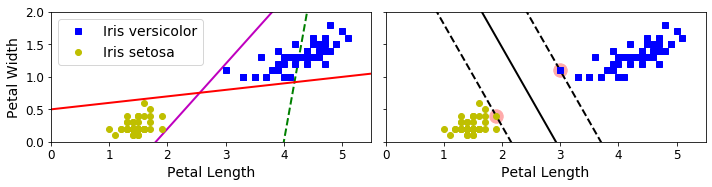

In [24]:
# Create a new figure with 2 sets of axes side-by-side
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(10, 2.7), sharey=True) 

# First axes: Bad linear classifiers 
plt.sca(axes[0])
plt.plot(x_0, pred_1, 'g--', linewidth=2)
plt.plot(x_0, pred_2, 'm-', linewidth=2)
plt.plot(x_0, pred_3, 'r-', linewidth=2)

# Plot versicolor samples as blue squares
plt.plot(X[:, 0][y == 1], X[:, 1][y == 1], 'bs', label='Iris versicolor')
plt.plot(X[:, 0][y == 0], X[:, 1][y == 0], 'yo', label='Iris setosa')

# Annotate the plot
plt.xlabel('Petal Length', fontsize=14)
plt.ylabel('Petal Width', fontsize=14)
plt.legend(loc='upper left', fontsize=14)
plt.axis([0, 5.5, 0, 2]);

# Second axes: SVM Classifier
plt.sca(axes[1])

# Use pre-written function for this plot
plot_svc_decision_boundary(svm_clf, 0, 5.5)

# Still plotting samples in different shapes and colors 
plt.plot(X[:, 0][y == 1], X[:, 1][y == 1], 'bs', label='Iris versicolor')
plt.plot(X[:, 0][y == 0], X[:, 1][y == 0], 'yo', label='Iris setosa')

# Will still have to labe the x-axis
plt.xlabel('Petal Length', fontsize=14)
plt.axis([0, 5.5, 0, 2])


save_fig('large_margin_classification_plot')

# Sensitivity to Feature Scaling 

SVMs are one of many machine learning models that are sensitive to feature scales. If one feature is much larger in magnitude than others, it can drastically skew the decision boundary and support vectors.

In [25]:
# Generating features and labels - each feature is a point in 2D space
Xs = np.array([[1, 50], [5, 20], [3, 80], [5, 60]]).astype(np.float64)
ys = np.array([0, 0, 1, 1,])

In [26]:
# Instantiating an SVM classifier to fit to unscaled data
svm_clf = SVC(kernel='linear', C=100)     # Some margin violations 
svm_clf.fit(Xs, ys)

SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [31]:
# Train a second SVM classifer that is fit to scaled (standardized) data
from sklearn.preprocessing import StandardScaler

In [32]:
# Scale the features to have mean 0 and standard deviation of 1 
X_scaled = StandardScaler().fit_transform(Xs)

In [33]:
# Fit the SVM to the scaled data
svm_clf_scaled = SVC(kernel='linear', C=100)
svm_clf_scaled.fit(X_scaled, ys)

SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

Saving figure sensitivity_to_feature_scales_plot


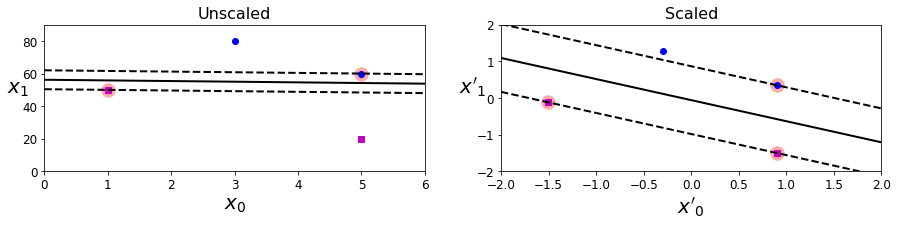

In [44]:
# Plot to compare the classification boundaries of both SVMs
plt.figure(figsize=(15, 2.7))

# First plot - unscaled data classifier
plt.subplot(121)
plt.plot(Xs[:, 0][ys == 1], Xs[:, 1][ys == 1], 'bo') # Blue circles
plt.plot(Xs[:, 0][ys == 0], Xs[:, 1][ys == 0], 'ms') # Magenta squares
plot_svc_decision_boundary(svm_clf, 0, 6)
plt.xlabel("$x_0$", fontsize=20)
plt.ylabel("$x_1$", fontsize=20, rotation=0)
plt.title("Unscaled", fontsize=16)
plt.axis([0, 6, 0, 90])

# Second plot - standardized data classifier
plt.subplot(122)
plt.plot(X_scaled[:, 0][ys == 1], X_scaled[:, 1][ys == 1], 'bo')
plt.plot(X_scaled[:, 0][ys == 0], X_scaled[:, 1][ys == 0], 'ms')
plot_svc_decision_boundary(svm_clf_scaled, -2, 2)   # x-range changed 
plt.xlabel("$x'_0$", fontsize=20)
plt.ylabel("$x'_1$", fontsize=20, rotation=0)
plt.title("Scaled", fontsize=16)
plt.axis([-2, 2, -2, 2])

save_fig('sensitivity_to_feature_scales_plot', tight_layout=False)

# Sensitivity to Outliers

We will see that the addition of just one sample to the iris dataset can drastically alter the SVM classification boundary if it happens to be an outlier.

In [50]:
# Create an array of 2D outliers 
X_outliers = np.array([[3.4, 1.3], [3.2, 0.8]])

# Also their labels - both new samples are versicolor
y_outliers = np.array([0, 0])

# Not linearly separable set of features and samples
Xo1 = np.concatenate([X, X_outliers[:1]], axis=0)
yo1 = np.concatenate([y, y_outliers[:1]], axis=0)

# Linearly separable set of features and samples
Xo2 = np.concatenate([X, X_outliers[1:]], axis=0)
yo2 = np.concatenate([y, y_outliers[1:]], axis=0)

In [51]:
# Linear SVM can only be applied to linearly separable data
svm_clf2 = SVC(kernel='linear', C = 10 ** 9)  # Hard margin classification
svm_clf2.fit(Xo2, yo2)

SVC(C=1000000000, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

Saving figure sensitivity_to_outliers_plot


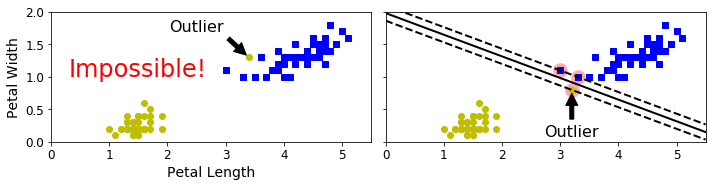

In [54]:
# Plotting the effect of outlier addition 
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(10, 2.7), sharey=True)

# First plot - not linearly separable 
plt.sca(axes[0])
plt.plot(Xo1[:, 0][yo1 == 1], Xo1[:, 1][yo1 == 1], 'bs')
plt.plot(Xo1[:, 0][yo1 == 0], Xo1[:, 1][yo1 == 0], 'yo')
plt.text(0.3, 1.0, 'Impossible!', fontsize=24, color='red')
plt.xlabel('Petal Length', fontsize=14)
plt.ylabel('Petal Width', fontsize=14)
plt.annotate('Outlier', 
             xy=(X_outliers[0][0], X_outliers[0][1]),       # Point to the first outlier 
             xytext=(2.5, 1.7),                             # Coordinates of top-right corner of text 
             ha='center',                                   # Arrow head's center aligned with target
             arrowprops=dict(facecolor='black', shrink=0.1),# Properties for the arrow's appearance 
             fontsize=16)
plt.axis([0, 5.5, 0, 2])

# Second plot - linearly separable, but SVM classification boundary shifted
plt.sca(axes[1])
plt.plot(Xo2[:, 0][yo2 == 1], Xo2[:, 1][yo2 == 1], 'bs')
plt.plot(Xo2[:, 0][yo2 == 0], Xo2[:, 1][yo2 == 0], 'yo')
plot_svc_decision_boundary(svm_clf2,  0, 5.5)
plt.annotate('Outlier', 
            xy=(X_outliers[1][0], X_outliers[1][1]), 
            xytext=(3.2, 0.08), 
            ha='center', 
            arrowprops=dict(facecolor='black', shrink=0.1), 
            fontsize=16)
plt.axis([0, 5.5, 0, 2]);

save_fig('sensitivity_to_outliers_plot')

# Soft Margin Classification

A hard margin classifier attempts to fit a classification boundary and margin such that there are as few margin violations as possible. Margin violations occur when
- a sample of a class is inside rather than outside the margin.
- a sample of a class is on the wrong side of the classification boundary. 

The greater the degree of hard margin classification, the narrower the margin around the classification boundary.

Hard margin classifiers
- cannot be fit to data that is not linearly separable. 
- very sensitive to outliers 

Soft margin classifiers, on the other hand, allow for some margin violations. They can be fit to data that isn't linearly separable. The margin is wider, but the margin violations increase. 

Hard margin classifiers: narrower margin, fewer margin violations, larger value of `C`. 
Soft margin classifiers: wider margin, more margin violations, smaller value of `C`.

## Example 5-1

In [55]:
import numpy as np
from sklearn import datasets 
from sklearn.pipeline import Pipeline 
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

In [56]:
# Load the dataset 
iris = datasets.load_iris()

# Extract features and targets
X = iris['data'][:, (2, 3)]   # Petal length, petal width
y = (iris['target'] == 2).astype(np.float64)   # Iris virginica - why floats?

Will create a `Pipeline` object that will pass input features `X` and labels `y` sequentially to a `StandardScaler` and `LinearSVC` object's `fit` methods with a single command. 

In [57]:
svm_clf = Pipeline([
    ('scaler', StandardScaler()),
    ('linear_svc', LinearSVC(C=1, loss='hinge', random_state=42)),
])

In [58]:
# Scaler.fit(X, y) -> SVC.fit(X, y)
svm_clf.fit(X, y)

Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('linear_svc', LinearSVC(C=1, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='hinge', max_iter=1000, multi_class='ovr',
     penalty='l2', random_state=42, tol=0.0001, verbose=0))])

In [59]:
# It will still be able to make predictions
svm_clf.predict([[5.5, 1.7]])

array([1.])

It predicts classes as floating point values, and not probabilities.

## Comparing Regularization Settings

In [60]:
# Instantiating a StandardScaler separately 
scaler = StandardScaler()

# First LinearSVC - small C, little regularization, wide margin, more margin violations
svm_clf1 = LinearSVC(C=1, loss='hinge', random_state=42)

# Second LinearSVC - large C, high regularization, narrow margin, fewer margin violations
svm_clf2 = LinearSVC(C=100, loss='hinge', random_state=42)

In [63]:
# Making separate pipelines 

# Low regularization
scaled_svm_clf1 = Pipeline([
    ('scaler', scaler), 
    ('linear_svc', svm_clf1)
])

# High regularization
scaled_svm_clf2 = Pipeline([
    ('scaler', scaler), 
    ('linear_svc', svm_clf2)
])

In [64]:
# Fit both models using the same data
scaled_svm_clf1.fit(X, y)
scaled_svm_clf2.fit(X, y)

/Users/saadmashkoor/.local/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('linear_svc', LinearSVC(C=100, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='hinge', max_iter=1000, multi_class='ovr',
     penalty='l2', random_state=42, tol=0.0001, verbose=0))])

## Plotting Prep

Will need to extract the weights, biases, and support vectors of the linear SVCs and rescale them so that they can be plotted on a graph with the unscaled data.

In [65]:
# Biases
b1 = svm_clf1.decision_function([-scaler.mean_ / scaler.scale_])
b2 = svm_clf2.decision_function([-scaler.mean_ / scaler.scale_])

# Weights
w1 = svm_clf1.coef_[0] / scaler.scale_
w2 = svm_clf2.coef_[0] / scaler.scale_

# Redefining `intercept` property of both SVM classifiers
svm_clf1.intercept_ = np.array([b1])
svm_clf2.intercept_ = np.array([b2])

# Redefining the coefficients to unscaled weight arrays
svm_clf1.coef_ = np.array([w1])
svm_clf2.coef_ = np.array([w2])

In [66]:
# Find the support vectors - LinearSVC does not do this automatically
t = y * 2 - 1 

# Constraint for linear SVC = t_i(W'x_i + b) >= 1 for i = 1, 2, 3, ..., m 
# Extracting all indexes of X that correspond to support vectors
support_vectors_idx1 = (t * (X.dot(w1) + b1) < 1).ravel()
support_vectors_idx2 = (t * (X.dot(w2) + b2) < 1).ravel()

# Update the support_vectors_ property in the classifiers
svm_clf1.support_vectors_ = X[support_vectors_idx1]
svm_clf2.support_vectors_ = X[support_vectors_idx2]

## Plotting

Saving figure regularization_plot


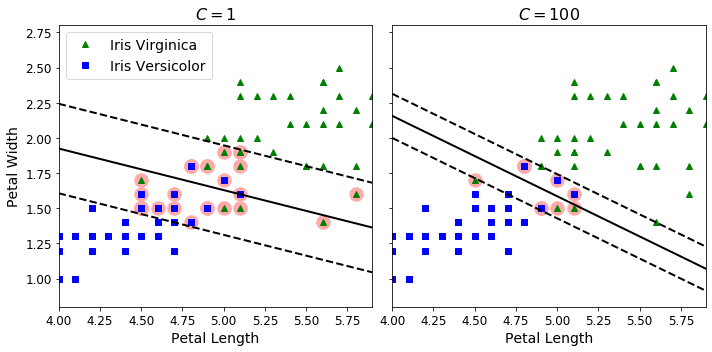

In [71]:
fig, axes = plt.subplots(ncols=2, figsize=(10, 5), sharey=True)

# First plot - low regularization
plt.sca(axes[0])
plt.plot(X[:, 0][y == 1], X[:, 1][y == 1], 'g^', label='Iris Virginica')   
plt.plot(X[:, 0][y == 0], X[: ,1][y == 0], 'bs', label='Iris Versicolor')   
plot_svc_decision_boundary(svm_clf1, 4, 5.9)
plt.xlabel('Petal Length', fontsize=14)
plt.ylabel('Petal Width', fontsize=14)
plt.legend(loc='upper left', fontsize=14)
plt.title('$C = {}$'.format(svm_clf1.C), fontsize=16)
plt.axis([4, 5.9, 0.8, 2.8])

# Second plot - large regularization
plt.sca(axes[1])
plt.plot(X[:, 0][y == 1], X[:, 1][y == 1], 'g^')
plt.plot(X[:, 0][y == 0], X[:, 1][y == 0], 'bs')
plot_svc_decision_boundary(svm_clf2, 4, 5.9)
plt.xlabel('Petal Length', fontsize=14)
plt.title('$C = {}$'.format(svm_clf2.C), fontsize=16)
plt.axis([4, 5.9, 0.8, 2.8])

save_fig('regularization_plot')

The plot on the left shows a linear SVM classifier with low regularization:  with the value of `C` set to 1, the margin around the classifier is larger, which leads to more margin violations (all samples labeled in red circles). 

The classifier on the right is trained on the same data as the left, but with a higher regularization strength. With `C` = 100, the margin is narrower, so there are fewer margin violations. 

In both cases, however, the dataset was not linearly separable. Yet, we were still able to fit a linear SVM classifier to them. This would not have been possible if with a hard margin classifier (with `C` = $\infty$).

# Non-Linear SVMs

## Polynomial Features

In [7]:
X1D = np.linspace(-4, 4, 9).reshape(-1, 1)    # 1-dimensional vector
X2D = np.c_[X1D, X1D ** 2]                    # 2nd degree polynomial as 2nd feature - column vectors
y = np.array([0, 0, 1, 1, 1, 1, 1, 0, 0])     # Labels

Saving figure higher_dimensions_plot


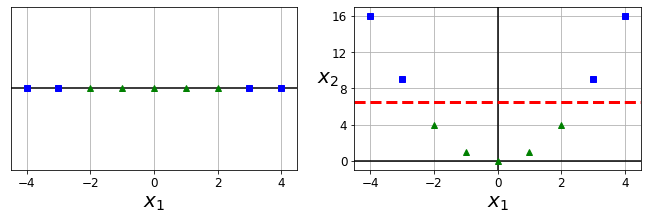

In [16]:
# Plotting figures to visualize effect of polynomial features
plt.figure(figsize=(10, 3))

# First plot - non-linearly separable data with single feature
plt.subplot(121)
plt.grid(True, which='both')
plt.axhline(y=0, color='k')                      # x-axis at y = 0, becomes darker
plt.plot(X1D[:, 0][y == 0], np.zeros(4), 'bs')   # Label = 0? Blue squares plotted on y = 0 (x-axis)
plt.plot(X1D[:, 0][y == 1], np.zeros(5), 'g^')   # Label = 1? Green triangles plotted on y = 0 (x-axis)
plt.gca().get_yaxis().set_ticks([])              # No ticks on the y-axis for this graph
plt.xlabel(r'$x_1$', fontsize=20)
plt.axis([-4.5, 4.5, -0.2, 0.2])

# Second plot - linearly separable data with additional polynomial features
plt.subplot(122)

# x and y axes are to be highlighted in black
plt.grid(True, which='both')
plt.axhline(y=0, color='k')
plt.axvline(x=0, color='k')

# Extracting 2D features based on their labels - plotting with separate markers
plt.plot(X2D[:, 0][y == 0], X2D[:, 1][y == 0], 'bs')
plt.plot(X2D[:, 0][y == 1], X2D[:, 1][y == 1], 'g^')
plt.xlabel(r'$x_1$', fontsize=20)
plt.ylabel(r'$x_2$', fontsize=20, rotation=0)
plt.gca().get_yaxis().set_ticks([0, 4, 8, 12, 16])

# Red dashed line to indicate the classification boundary - linear because of quadratic data
plt.plot([-4.5, 4.5], [6.5, 6.5], 'r--', linewidth=3)
plt.axis([-4.5, 4.5, -1, 17])

# Moving right subplot by 1 unit so that y-axis label does not overlap with graph
plt.subplots_adjust(right=1)

save_fig('higher_dimensions_plot', tight_layout=False)
plt.show()

## Moons Dataset 

The `moons` dataset is prepackaged with `sklearn`. It is a toy dataset that creates a binary, non-lineary separable dataset. We will use this dataset to illustrate the use of polynomial features and non-linear support vector machines.

In [17]:
from sklearn.datasets import make_moons
X, y = make_moons(n_samples=100, noise=0.15, random_state=42)

In [18]:
def plot_dataset(X, y, axes):
    # Plotting samples of the two classes with different markers
    plt.plot(X[:, 0][y == 0], X[:, 1][y == 0], 'bs')
    plt.plot(X[:, 0][y == 1], X[:, 1][y == 1], 'g^')
    
    # Using argument-specified axes limits
    plt.axis(axes)
    
    # Annotating plot
    plt.grid(True, which='both')
    plt.xlabel(r'$x_1$', fontsize=20)
    plt.ylabel(r'$x_2$', fontsize=20, rotation=0)

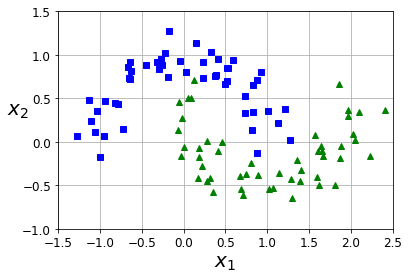

In [20]:
# Plotting the moons dataset
plot_dataset(X, y, [-1.5, 2.5, -1, 1.5])
plt.show()

Thee data generated by the `make_moons` command will always consist of two interleaving half circles 

## SVM Classifier with Polynomial Features

In [25]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.svm import LinearSVC

In [26]:
# Pipeline object consisting of a polynomial feature transformer, a standard scaler, and a linear SVM
polynomial_svm_clf = Pipeline([
    ('poly_features', PolynomialFeatures(degree=3)), 
    ('scaler', StandardScaler()), 
    ('svm_clf', LinearSVC(loss='hinge', C=10))
])

In [29]:
# `Fit` will call `fit_transform` of poly_features and scaler, and `fit` of SVM
polynomial_svm_clf.fit(X, y)

Pipeline(memory=None,
     steps=[('poly_features', PolynomialFeatures(degree=3, include_bias=True, interaction_only=False)), ('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('svm_clf', LinearSVC(C=10, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='hinge', max_iter=1000, multi_class='ovr',
     penalty='l2', random_state=None, tol=0.0001, verbose=0))])

In [32]:
def plot_predictions(clf, axes):
    # Feature spaces - 100 linearly spaced values between min and max x and y axes values
    x0s = np.linspace(axes[0], axes[1], 100)
    x1s = np.linspace(axes[2], axes[3], 100)
    
    # Create a grid of (x0, x1) values
    x0, x1 = np.meshgrid(x0s, x1s)
    
    # Transform the grid into a matrix of 2D features for prediction
    X = np.c_[x0.ravel(), x1.ravel()]
    
    # Make predictions on the features - reshape so that 1 pred per feature
    y_pred = clf.predict(X).reshape(x0.shape)
    
    # Decision function is classification boundary?
    y_decision = clf.decision_function(X).reshape(x0.shape)
    
    plt.contourf(x0, x1, y_pred, cmap=plt.cm.brg, alpha=0.2)
    plt.contourf(x0, x1, y_decision, cmap=plt.cm.brg, alpha=0.1)

Saving figure moons_polynomial_svc_plot


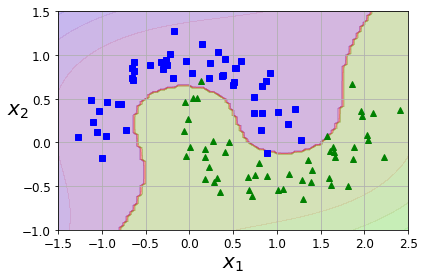

In [33]:
# Visualize decision boundary and dataset on same graph
plot_predictions(polynomial_svm_clf, [-1.5, 2.5, -1, 1.5])
plot_dataset(X, y, [-1.5, 2.5, -1, 1.5])
save_fig('moons_polynomial_svc_plot')
plt.show()

Using polynomial features, we have been able to figure out a non-linear decision boundary while still using a linear support vector machine classifier. Is this because of kernel trick?

# Kernel Trick with SVC

Low degree polynomials cannot usually deal with very complex datasets. However, adding a high degree polynomial can create a huge number of features, which can make the model too slow (because there will be a combinatorial explosion of features - third degree polynomial will not just contain features made by all possible combinations of three features but also all possible combinations of two features).

However, when using SVC, we can use a **kernel trick**. A kernel trick maps a set of input vectors from a lower dimensional space - where they may not be linearly separable - to a higher dimensional space, where they may be linear separable, without actually computing all the polynomial features required for this. This is done by passing the input feature to a **kernel function** which uses a dot product of the original vectors in lower-dimensional space to yield the same result as all polynomial features in higher dimensional space.

In [35]:
from sklearn.svm import SVC

In [36]:
poly_kernel_svm_clf = Pipeline([
    ('scaler', StandardScaler()), 
    ('svm_clf', SVC(kernel='poly', degree=3, coef0=1, C=5))
])

This a kernelized implementation of the same classifer we implemented earlier. Value of `C` - the SVM regularization factor - is very low, which means regularization is very low, which means this is a soft margin classifier: it will allow some margin violations. 

The `degree` is 3: this means we will still be using polynomial features upto the third degree to find a classification boundary between the two classes. 

`coef0` controls how much the model is influenced by high-degree polynomials rather than low-degree polynomials. 

However, the `kernel` being poly means we are a using a polynomial kernel function (of `degree` 3). This kernel will help us optimise a quadratic equation for finding the decision boundary using the values returned by a third-degree polynomial's cost function, without actually computing all the features in the third-degree polynomial.

In [37]:
poly_kernel_svm_clf.fit(X, y)

Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('svm_clf', SVC(C=5, cache_size=200, class_weight=None, coef0=1,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='poly', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False))])

In [38]:
# Training another kernelized polynomial SVM but with higher degree. Affected more by lower degree polynomials
poly_100_kernel_svm_clf = Pipeline([
    ('scaler', StandardScaler()), 
    ('svm_clf', SVC(kernel='poly', degree=10, coef0=100, C=5))
])

In [39]:
poly_100_kernel_svm_clf.fit(X, y)

Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('svm_clf', SVC(C=5, cache_size=200, class_weight=None, coef0=100,
  decision_function_shape='ovr', degree=10, gamma='auto_deprecated',
  kernel='poly', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False))])

## Comparing Effect of `degree`

Model on the left has been trained using a polynomial kernel of lower degree (3) - this means features upto the the third degree are used to figure out a decision boundary.

Model on the right has been trained using a polynomial kernel of higher degree (10) - this means features upto the 10th degree are used to figure out a decision boundary. 

Both models have the same degree of regularization (as indicated by `C`) - both are soft margin classifiers. 

However, the model on the left is less influenced by lower degree polynomials than the one on the right.

Saving figure moons_kernelized_polynomial_svc_plot


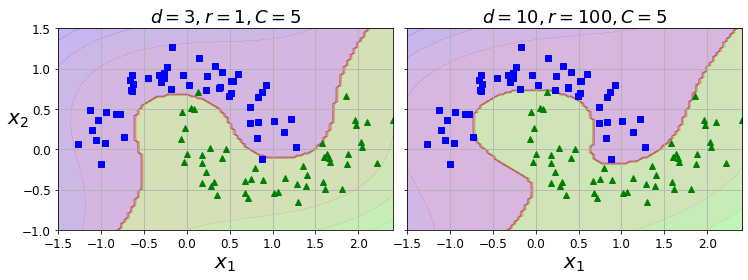

In [43]:
fig, axes = plt.subplots(ncols=2, figsize=(10.5, 4), sharey=True)

# First plot - 3rd degree polynomial kernel
plt.sca(axes[0])
plot_predictions(poly_kernel_svm_clf, [-1.5, 2.45, -1, 1.5])
plot_dataset(X, y, [-1.5, 2.4, -1, 1.5])
plt.title(r'$d=3, r=1, C=5$', fontsize=18)

# Second plot - 10th degree polynomial kernel
plt.sca(axes[1])
plot_predictions(poly_100_kernel_svm_clf, [-1.5, 2.45, -1, 1.5])
plot_dataset(X, y, [-1.5, 2.4, -1, 1.5])

# Hide the y-label - otherwise it overlaps with the first plot
plt.ylabel('')
plt.title(r'$d=10, r=100, C=5$', fontsize=18)

save_fig('moons_kernelized_polynomial_svc_plot')
plt.show()

# Similarity Features 

Instead of simply adding features that are polynomial combinations of existing features, we can also use **similarity** functions to create new features that measure how 'similar' a given sample is to a specified landmark.

One such similarity function is the **Gaussian Radial Basis Function**. 

$\phi_{\gamma}(\textbf{x}, l) = exp(-\gamma\times||x - l||^2)$

The RBF similarity function returns a value of 1 if the value of $\textbf{x}$ is close to the landmark $l$. The value decreases and approaches 0 the farther the value of $\textbf{x}$ is from the landmark.

In [45]:
def gaussian_rbf(x, landmark, gamma):
    """Returns a similarity score between `x` and `landmark` using coefficient gamma"""
    return np.exp(-gamma * np.linalg.norm(x - landmark, axis=1) ** 2)

In [46]:
# Defining gamma to be the 0.3 for this demonstration
gamma = 0.3

In [47]:
# One dimensional dataset is composed of 200 values between +- 4.5
x1s = np.linspace(-4.5, 4.5, 200).reshape(-1, 1)

In [49]:
# Two different similarity scores based on two different landmarks
x2s = gaussian_rbf(x1s, -2, gamma)
x3s = gaussian_rbf(x1s, 1, gamma)

In [51]:
# X1D is the 1-dimensional set of features from polynomial svm example
X1D

array([[-4.],
       [-3.],
       [-2.],
       [-1.],
       [ 0.],
       [ 1.],
       [ 2.],
       [ 3.],
       [ 4.]])

In [53]:
# One column per each new landmark-based feature
XK = np.c_[gaussian_rbf(X1D, -2, gamma), gaussian_rbf(X1D, 1, gamma)]
yk = np.array([0, 0, 1, 1, 1, 1, 1, 0, 0])

Saving figure kernel_method_plot


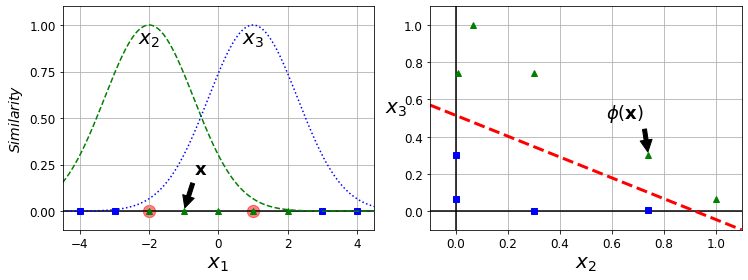

In [59]:
plt.figure(figsize=(10.5, 4))
plt.subplot(121)
plt.grid(True, which='both')
plt.axhline(y=0, color='k')

# Create red circles around the landmarks at x = -2 and x = 1
plt.scatter(x=[-2, 1], y=[0, 0], s=150, alpha=0.5, c='red')

# Plot original 1D data
plt.plot(X1D[:, 0][yk == 0], np.zeros(4), 'bs')
plt.plot(X1D[:, 0][yk == 1], np.zeros(5), 'g^')

plt.plot(x1s, x2s, 'g--')
plt.plot(x1s, x3s, 'b:')

plt.gca().get_yaxis().set_ticks([0, 0.25, 0.5, 0.75, 1])
plt.xlabel(r'$x_1$', fontsize=20)
plt.ylabel(r'$Similarity$', fontsize=14)
plt.annotate(r'$\mathbf{x}$',         
            xy=[X1D[3, 0], 0],             
            xytext=(-0.5, 0.20), 
            ha='center', 
            arrowprops=dict(facecolor='black', shrink=0.1), 
            fontsize=18)
plt.text(-2, 0.9, "$x_2$", ha="center", fontsize=20)
plt.text(1, 0.9, "$x_3$", ha="center", fontsize=20)
plt.axis([-4.5, 4.5, -0.1, 1.1])


plt.subplot(122)
plt.grid(True, which='both')
plt.axhline(y=0, color='k')
plt.axvline(x=0, color='k')
plt.plot(XK[:, 0][yk == 0], XK[:, 1][yk == 0], 'bs')
plt.plot(XK[:, 0][yk == 1], XK[:, 1][yk == 1], 'g^')
plt.xlabel(r"$x_2$", fontsize=20)
plt.ylabel(r"$x_3$  ", fontsize=20, rotation=0)
plt.annotate(r'$\phi\left(\mathbf{x}\right)$',
             xy=(XK[3, 0], XK[3, 1]),
             xytext=(0.65, 0.50),
             ha="center",
             arrowprops=dict(facecolor='black', shrink=0.1),
             fontsize=18,
            )
plt.plot([-0.1, 1.1], [0.57, -0.1], "r--", linewidth=3)
plt.axis([-0.1, 1.1, -0.1, 1.1])
    
plt.subplots_adjust(right=1)

save_fig("kernel_method_plot")
plt.show()

What we did here was specify two landmarks in the origina input feature $x_1$'s domain of values. 

Then we computed two new features $x_2$ and $x_3$ that are scores of how similar a given instance in $x_1$ is to the landmarks $x_1 = -1$ and $x_1 = 2$. Based on this, we now have a new 2-dimensional feature space of all possible $x_2$ and $x_3$ values, which have resulted in linearly separable data.

The easiest way to choose a landmark is to make a landmark at every single sample in the dataset. This creates an $m \times m$ dimensional data, which means we now have $m$ different features for each sample.

# SVM with Similarity Features

In [64]:
rbf_kernel_svm_clf = Pipeline([
    ('scaler', StandardScaler()), 
    ('svm_clf', SVC(kernel='rbf', gamma=5, C=0.001))
])

### RBF Kernel
By specifying an `rbf` value for the `kernel` argument, we have made an SVM that 
- uses the similarity scores between landmarks and instances of the training set to create `m` new features
- finds a decision boundary on the basis of this new `m`-dimensional space 
- but uses a kernel function to find the classification boundary without actually having to compute the `m` different similarity score results.  

### C
Because the value of `C` is very small, regularization is very small, which means the resulting SVM classifier allows a lot of margin violations.

### Gamma
`gamma` control the 'width' of the bell-shape curved around each landmark, and thus the similarity score computed for each instance. **The larger the value of `gamma`, the narrower the curve.** Increasing the value of `gamma` therefore means the range of influence of each sample is smaller, which results in the decision boundary being more irregular.

In comparison, smaller values of `gamma` mean the decision boundary is smoother, because the zone of influence of a single sample maps with others. 

- Overfitting? Reduce `gamma`.
- Underfitting? Increas `gamma`.

In [65]:
rbf_kernel_svm_clf.fit(X, y)

Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('svm_clf', SVC(C=0.001, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=5, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))])

## Comparing `RBF` Hyperparameters

In [78]:
from sklearn.svm import SVC

In [79]:
# Possible values - zone of influence for similarity scores
gamma1, gamma2 = 0.1, 5

In [80]:
# Possible values - regularization strength
C1, C2 = 0.001, 1000

In [81]:
# Possible combinations of hyperparameters for RBF kernelized SVM
hyperparams = (gamma1, C1), (gamma1, C2), (gamma2, C1), (gamma2, C2)

In [82]:
# List of SVM classifiers
svm_clfs = []

In [83]:
for (gamma, C) in hyperparams:
    # Create a new RBF kernelized SVM 
    rbf_kernel_svm_clf = Pipeline([
        ('scaler', StandardScaler()), 
        ('svm_clf', SVC(kernel='rbf', gamma=gamma, C=C))
    ])
    
    # Fit this SVM to the training data
    rbf_kernel_svm_clf.fit(X, y)
    
    # Append the fitted SVM to the list of SVMs
    svm_clfs.append(rbf_kernel_svm_clf)

Saving figure moons_rbf_svc_plot


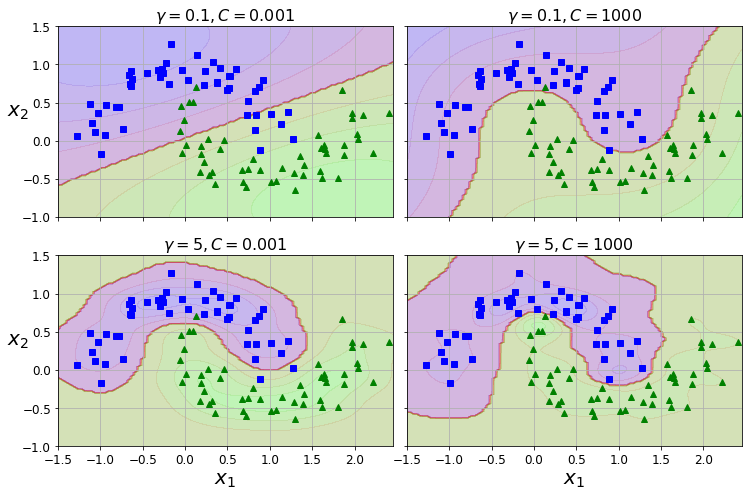

In [89]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10.5, 7), sharex=True, sharey=True)

for i, svm_clf in enumerate(svm_clfs): 
    # Clever way to iterate through axes - row updated after two plots, column after every plot
    plt.sca(axes[i // 2, i % 2])
    
    # Plot the prediction boundary for this SVM for the specified axes
    plot_predictions(svm_clf, [-1.5, 2.45, -1, 1.5])
    
    # Plot the actual dataset for the same axes
    plot_dataset(X, y, [-1.5, 2.45, -1, 1.5])
    
    # Add the hyperparameters to the title
    gamma, C = hyperparams[i]
    plt.title(r'$\gamma = {}, C = {}$'.format(gamma, C), fontsize=16)
    
    # No x-label if the first row - because will overlap with plots in lower row 
    if i in (0, 1):
        plt.xlabel("")
        
    # No y-label if plot in 2nd column - shared y axis
    if i in (1, 3):
        plt.ylabel('')

save_fig('moons_rbf_svc_plot')
plt.show()

As the value of `y` increases, the decision boundary becomes more irregular.  
As the value of `C` increases, the region belonging to class 2 become smaller. 

# SVM Regression

The objective changes when we're using SVMs for regression. Instead of trying to fit the largest possible 'street' between two classes while minimising the number of margin violations (samples on the street), the SVM regression tries to fit as many instances as possible on the street while limiting margin violations (samples off the street).

Street width is controlled by $\epsilon$. Larger value of `epsilon` means larger street, and fewer margin violations.

## First Example - Linear SVM

In [92]:
# Seed random number generator
np.random.seed(42)

# Number of samples
m = 50

# Features - linearly distributed
X = 2 * np.random.rand(m, 1)

# Targets - straight line with intercept of 4 and slope of 3
y = (4 + 3 * X + np.random.randn(m, 1)).ravel()

In [93]:
from sklearn.svm import LinearSVR

In [94]:
# Instantiate a regressor
svm_reg = LinearSVR(epsilon=1.5, random_state=42)
svm_reg.fit(X, y)

LinearSVR(C=1.0, dual=True, epsilon=1.5, fit_intercept=True,
     intercept_scaling=1.0, loss='epsilon_insensitive', max_iter=1000,
     random_state=42, tol=0.0001, verbose=0)

## Effect of $\epsilon$ - 'Street Width'

In [110]:
# Creating two different SVRegressors - one has wider street, one is very narrow
svm_reg1 = LinearSVR(epsilon=1.5, random_state=42)
svm_reg2 = LinearSVR(epsilon=0.5, random_state=42)

In [111]:
# Fitting to the same data - not scaling?
svm_reg1.fit(X, y)
svm_reg2.fit(X, y)

LinearSVR(C=1.0, dual=True, epsilon=0.5, fit_intercept=True,
     intercept_scaling=1.0, loss='epsilon_insensitive', max_iter=1000,
     random_state=42, tol=0.0001, verbose=0)

In [112]:
def find_support_vectors(svm_reg, X, y):
    # Find the predicted values using a trained SVM
    y_pred = svm_reg.predict(X)
    
    # Margin violations occur when the norm of the distance between actual and 
    # predicted values is greater than the width of the street i.e. epsilon
    off_margin = (np.abs(y - y_pred) >= svm_reg.epsilon)
    
    # Return the indices of the (first?) vectors that are off the street
    return np.argwhere(off_margin)

In [115]:
svm_reg1.support_ = find_support_vectors(svm_reg1, X, y)
svm_reg2.support_ = find_support_vectors(svm_reg2, X, y)

In [116]:
eps_x1 = 1

In [117]:
eps_y_pred = svm_reg1.predict([[eps_x1]])

In [124]:
def plot_svm_regression(svm_reg, X, y, axes):
    # Input space - 100 values between specified min and max x-axis values
    x1s = np.linspace(axes[0], axes[1], 100).reshape(100, 1)
    
    # Predictions made on all values in input space
    y_pred = svm_reg.predict(x1s)
    
    # Plot predictions as a solid black line
    plt.plot(x1s, y_pred, 'k-', linewidth=2, label=r'$\hat{y}$')
    
    # Gutters plotted as dotted black lines
    plt.plot(x1s, y_pred + svm_reg.epsilon, 'k--')
    plt.plot(x1s, y_pred - svm_reg.epsilon, 'k--')
    
    # Red circles around margin violations 
    plt.scatter(X[svm_reg.support_], y[svm_reg.support_], s=180, facecolors='#FFAAAA')
    
    # Training samples plotted as blue dots
    plt.plot(X, y, 'bo')
    plt.xlabel(r'$x_1$', fontsize=18)
    plt.legend(loc='upper left', fontsize=18)
    plt.axis(axes)

Saving figure svm_regression_plot


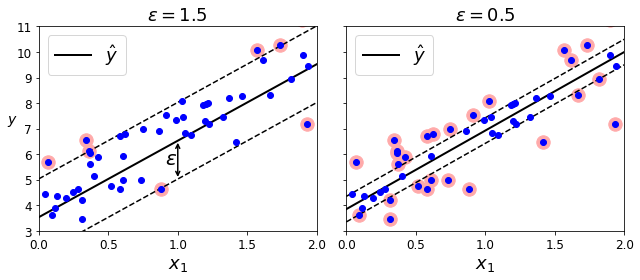

In [125]:
fig, axes = plt.subplots(ncols=2, figsize=(9, 4), sharey=True)
plt.sca(axes[0])
plot_svm_regression(svm_reg1, X, y, [0, 2, 3, 11])
plt.title(r'$\epsilon = {}$'.format(svm_reg1.epsilon), fontsize=18)
plt.ylabel(r'$y$', fontsize=14, rotation=0)
plt.annotate(
        '', xy=(eps_x1, eps_y_pred), xycoords='data',
        xytext=(eps_x1, eps_y_pred - svm_reg1.epsilon),
        textcoords='data', arrowprops={'arrowstyle': '<->', 'linewidth': 1.5}
    )
plt.text(0.91, 5.6, r"$\epsilon$", fontsize=20)
plt.sca(axes[1])
plot_svm_regression(svm_reg2, X, y, [0, 2, 3, 11])
plt.title(r"$\epsilon = {}$".format(svm_reg2.epsilon), fontsize=18)
save_fig("svm_regression_plot")
plt.show()

Increasing the value of `epsilon` led to a 'wider' street because of a larger margin, and thus fewer margin violations. 

Smaller value of `epsilon` led to a 'narrower' street because of a narrower margin, and thus more margin violations - samples that should have been 'on' the street but aren't.

# Kernelized SVM Regression

In [139]:
np.random.seed(42)
m = 100
X = 2 * np.random.rand(m, 1) - 1
y = (0.2 + 0.1 * X + 0.5 * X**2 + np.random.randn(m, 1)/10).ravel()

In [140]:
# Instantiating a kernelized Support Vector regressor
from sklearn.svm import SVR

svm_poly_reg = SVR(kernel='poly', degree=2, C=100, epsilon=0.1, gamma='scale')
svm_poly_reg.fit(X, y)

SVR(C=100, cache_size=200, coef0=0.0, degree=2, epsilon=0.1, gamma='scale',
  kernel='poly', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

## Comparing `C`

In [141]:
from sklearn.svm import SVR

In [142]:
# Instantiating
svm_poly_reg1 = SVR(kernel='poly', degree=2, C=100, epsilon=0.1, gamma='scale')
svm_poly_reg2 = SVR(kernel='poly', degree=2, C=0.01, epsilon=0.1, gamma='scale')

In [143]:
# Fitting 
svm_poly_reg1.fit(X, y)
svm_poly_reg2.fit(X, y)

SVR(C=0.01, cache_size=200, coef0=0.0, degree=2, epsilon=0.1, gamma='scale',
  kernel='poly', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

Saving figure svm_with_polynomial_kernel_plot


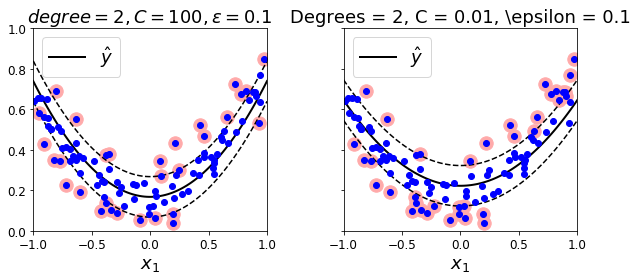

In [144]:
# Comparing effect of C on kernelized SVM regression
fig, axes = plt.subplots(ncols=2, figsize=(9, 4), sharey=True)

# First plot, little regularization
plt.sca(axes[0])
plot_svm_regression(svm_poly_reg1, X, y, [-1, 1, 0, 1])
plt.title(r'$degree = {}, C = {}, \epsilon = {}$'.format(svm_poly_reg1.degree, 
                                                         svm_poly_reg1.C, svm_poly_reg1.epsilon), 
          fontsize=18)

# Second plot - a lot of regularization
plt.sca(axes[1])
plot_svm_regression(svm_poly_reg2, X, y, [-1, 1, 0, 1])
plt.title(r'Degrees = {}, C = {}, \epsilon = {}'.format(svm_poly_reg2.degree, 
                                                      svm_poly_reg2.C, svm_poly_reg2.epsilon), 
        fontsize=18)

save_fig('svm_with_polynomial_kernel_plot')
plt.show()